Following this guide:
https://github.com/fzenke/spytorch/blob/main/notebooks/SpyTorchTutorial1.ipynb

<style>
  .invert {
    background-color: white;
    filter: invert(100%);
  }
</style>

<img class="invert" src="https://raw.githubusercontent.com/fzenke/spytorch/d363dbf93a04bf97b4819f1a41579bbbec17b1d2/notebooks/figures/mlp_sketch/mlp_sketch.png" ></img>

In [20]:
# Creating the simple feedforward network
nb_inputs = 100
nb_hidden = 4
nb_outputs = 2

In [21]:
# We are technically simulating an RNN, thus we need to stimulate our neurons for
# a certain number of time steps.
time_step = 1e-3
nb_steps = 200

In [22]:
# Specifiying the batch size
batch_size = 256

In [23]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import torch
import torch.nn as nn

In [24]:
dtype = torch.float
device = torch.device("cpu")

Generating a simple synthetic dataset
* This is just random spiking data, not meaningful input

In [25]:
# Filling a tensor (batch_size x nb_steps x nb_inputs) of random numbers between
# 1 and 0 to generate input data.

freq = 5 # Hz
prob = freq * time_step
mask = torch.rand((batch_size, nb_steps, nb_inputs), device=device, dtype=dtype) # Makes a tensor of random floats from 0 to 1
x_data = torch.zeros((batch_size, nb_steps, nb_inputs), device=device, dtype=dtype, requires_grad=False)
x_data[mask<prob] = 1.0

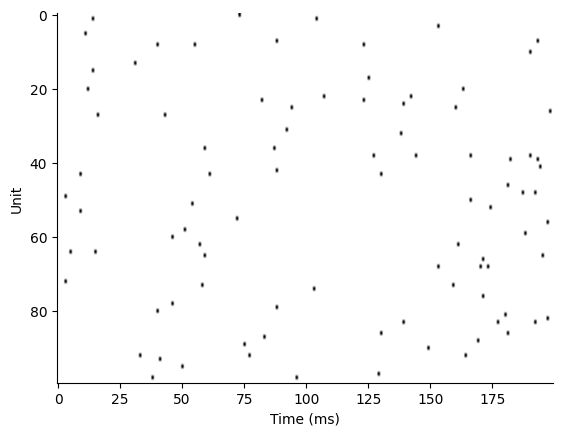

In [26]:
# Plotting the first input

data_id = 19
plt.imshow(x_data[data_id].cpu().t(), cmap=plt.cm.gray_r, aspect="auto")
plt.xlabel("Time (ms)")
plt.ylabel("Unit")
sns.despine()

In [27]:
# Now we just add random labels to the data, this I find very weird but whatever
y_data = torch.tensor(1 * (np.random.rand(batch_size) < 0.5), device=device)
y_data

tensor([1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
        0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1,
        0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,
        0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
        0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0])

In [28]:
# Setting some constants
tau_syn = 5e-3
tau_mem = 10e-3
alpha = float(np.exp(-time_step / tau_syn))
beta = float(np.exp(-time_step / tau_mem))

In [29]:
weight_scale = 7 * (1.0 - beta)

w1 = torch.empty((nb_inputs, nb_hidden), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))

w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=0., std=weight_scale/np.sqrt(nb_hidden))

print("init donbe")

init donbe


In [30]:
h1 = torch.einsum("abc,cd->abd", (x_data, w1)) # A way to specify how you want to do
                                               # your batch multiplication, kinda cool!

In [31]:
h1[:,199].shape

torch.Size([256, 4])

The spiking nonlinearity

In [32]:
def spike_fn(x):
  """
  Heavyside function
  """
  out = torch.zeros_like(x)
  out[x > 0] = 1.0

  return out

In [33]:
# Initializing the synaptic currents and the membrane potential
syn = torch.zeros((batch_size, nb_hidden), device=device, dtype=dtype)
mem = torch.zeros((batch_size, nb_hidden), device=device, dtype=dtype)
small_v = 1.0 # v in the heavyside function in the tutorial

# init lists to record membrane potentials and spikes
mem_rec = []
spk_rec = []

# Looping through time
for t in range(nb_steps):
  mthr = mem - small_v
  out = spike_fn(mthr)
  rst = out.detach() # We do not want to backprop through the rest

  new_syn = alpha * syn + h1[:,t]
  new_mem = (beta * mem + syn) * (1.0 - rst) # ??? I don't think this is right

  mem_rec.append(mem)
  spk_rec.append(out)

  mem = new_mem
  syn = new_syn

# Now we merge the recorded membrane potentials into a single tensor
mem_rec = torch.stack(mem_rec, dim=1)
spk_rec = torch.stack(spk_rec, dim=1)

print(spk_rec)

tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        ...,

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
 

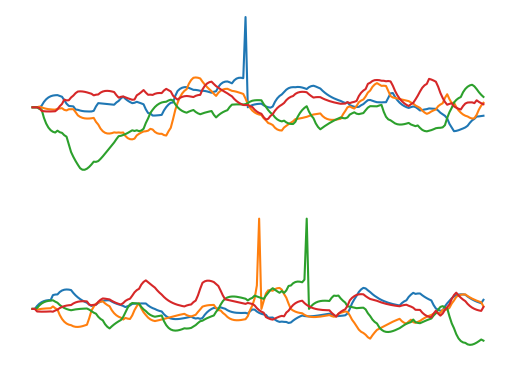

In [34]:
# Plotting the 4 nodes in the hidden layer

def plot_voltage_traces(mem, spk=None, dim=(2,1), spike_height=3): # spike height is arbitrary
    gs=GridSpec(*dim)
    if spk is not None:
        dat = 1.0*mem
        dat[spk>0.0] = spike_height
        dat = dat.detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i==0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i],sharey=a0)
        ax.plot(dat[i])
        ax.axis("off")

fig=plt.figure(dpi=100)
plot_voltage_traces(mem_rec, spk_rec)

In [35]:
mem_rec.shape
out.shape

torch.Size([256, 4])

Above is just the hidden layer, now we are adding a <b>readout layer</b>
* We will define a cost function by using the membrane potential of the outputs
* Most of this function is what we wrote above but in function form
* CRAZY that the network isn't one big for loop, that is kinda gang busters

In [40]:
def run_snn(inputs):
  """
  forward pass through the network
  """
  h1 = torch.einsum("abc,cd->abd", (inputs, w1))
  syn = torch.zeros((batch_size, nb_hidden), device=device, dtype=dtype)
  mem = torch.zeros((batch_size, nb_hidden), device=device, dtype=dtype)

  mem_rec = []
  spk_rec = []

  # Compute hidden layer activity
  for t in range(nb_steps):
    mthr = mem - 1.0
    out = spike_fn(mthr)
    rst = out.detach() # no backprop through the reset

    new_syn = alpha * syn + h1[:,t]
    new_mem = (beta * mem + syn) * (1.0 - rst)

    mem_rec.append(mem)
    spk_rec.append(out)

    mem = new_mem
    syn = new_syn

  # reformating
  mem_rec = torch.stack(mem_rec, dim=1)
  spk_rec = torch.stack(spk_rec, dim=1)

  # compute readout layer
  h2 = torch.einsum("abc,cd->abd", (spk_rec, w2)) # spk_rec is just a tensor of 1's and 0's
  flt = torch.zeros((batch_size, nb_outputs), device=device, dtype=dtype)
  out = torch.zeros((batch_size, nb_outputs), device=device, dtype=dtype)
  out_rec = [out] # Look at variable right above this, idk why he named it "out" twice lol
  for t in range(nb_steps):
    new_flt = alpha * flt + h2[:,t]
    new_out = beta * out + flt # Intentionally not including spikes in the output layer

    flt = new_flt
    out = new_out

    out_rec.append(out)

  out_rec = torch.stack(out_rec, dim=1)
  other_recs = [mem_rec, spk_rec]

  return out_rec, other_recs

torch.Size([256, 200, 4])


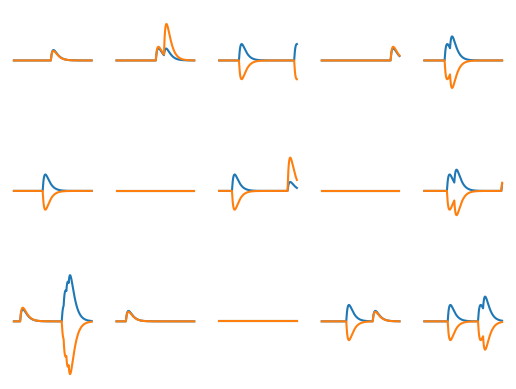

In [37]:
# Doing a forward pass and plotting the outputs
out_rec, other_recs = run_snn(x_data)
fig = plt.figure(dpi=100)
plot_voltage_traces(out_rec, dim=(3, 5))

In [38]:
# Computing the classification accuracy
def print_class_accuracy():
  """
  computes the classification accuracy.
  """
  output, _ = run_snn(x_data)

  # THE SAUCE OF LEARNING RIGHT HERE
  m, _ = torch.max(output, 1) # max over time
  _, am = torch.max(m, 1) # argmax over ouput units

  acc = np.mean((y_data==am).detach().cpu().numpy()) # compare to labels
  print("Accuracy %.3f"%acc)

print_class_accuracy()

torch.Size([256, 200, 4])
Accuracy 0.465


Supervised Learning

True Gradient

In [39]:
params = [w1, w2] # The params we want to optimize
optimizer = torch.optim.Adam(params, lr=2e-3, betas=(0.9, 0.999))

log_softmax_fn = nn.LogSoftmax(dim=1) # softmax function across output units
loss_fn = nn.NLLLoss() # loss

# Optimization loop
loss_hist = []
for e in range(1000):
  # Run the network and get output
  output, _ = run_snn(x_data)

  # Compute the loss
  m, _ = torch.max(output, 1)
  log_p_y = log_softmax_fn(m)
  loss_val = loss_fn(log_p_y, y_data)

  # Update the weights
  optimizer.zero_grad()
  loss_val.backward()
  optimizer.step()

  # store loss values
  loss_hist.append(loss_val.item())

loss_hist_true_grad = loss_hist

torch.Size([256, 200, 4])
torch.Size([256, 200, 4])
torch.Size([256, 200, 4])
torch.Size([256, 200, 4])
torch.Size([256, 200, 4])
torch.Size([256, 200, 4])
torch.Size([256, 200, 4])
torch.Size([256, 200, 4])
torch.Size([256, 200, 4])
torch.Size([256, 200, 4])
torch.Size([256, 200, 4])
torch.Size([256, 200, 4])
torch.Size([256, 200, 4])
torch.Size([256, 200, 4])
torch.Size([256, 200, 4])
torch.Size([256, 200, 4])
torch.Size([256, 200, 4])
torch.Size([256, 200, 4])
torch.Size([256, 200, 4])
torch.Size([256, 200, 4])
torch.Size([256, 200, 4])
torch.Size([256, 200, 4])
torch.Size([256, 200, 4])
torch.Size([256, 200, 4])
torch.Size([256, 200, 4])
torch.Size([256, 200, 4])
torch.Size([256, 200, 4])
torch.Size([256, 200, 4])
torch.Size([256, 200, 4])
torch.Size([256, 200, 4])
torch.Size([256, 200, 4])
torch.Size([256, 200, 4])
torch.Size([256, 200, 4])
torch.Size([256, 200, 4])
torch.Size([256, 200, 4])
torch.Size([256, 200, 4])
torch.Size([256, 200, 4])
torch.Size([256, 200, 4])
torch.Size([

In [42]:
log_p_y

tensor([[-0.9476, -0.4905],
        [-0.6190, -0.7732],
        [-0.5793, -0.8216],
        [-0.5343, -0.8821],
        [-0.5315, -0.8860],
        [-0.5793, -0.8216],
        [-0.6931, -0.6931],
        [-0.6599, -0.7275],
        [-0.6931, -0.6931],
        [-0.5952, -0.8017],
        [-0.5343, -0.8821],
        [-0.9476, -0.4905],
        [-0.6931, -0.6931],
        [-0.7812, -0.6122],
        [-0.5272, -0.8922],
        [-0.6931, -0.6931],
        [-0.7208, -0.6663],
        [-0.5343, -0.8821],
        [-0.5439, -0.8686],
        [-0.5387, -0.8759],
        [-0.6639, -0.7233],
        [-0.4664, -0.9868],
        [-0.9476, -0.4905],
        [-0.6599, -0.7275],
        [-0.7810, -0.6124],
        [-0.4196, -1.0709],
        [-0.4097, -1.0902],
        [-0.5310, -0.8868],
        [-0.6599, -0.7275],
        [-0.5564, -0.8517],
        [-0.5343, -0.8821],
        [-0.4231, -1.0642],
        [-0.6931, -0.6931],
        [-0.6931, -0.6931],
        [-0.4419, -1.0295],
        [-0.6951, -0

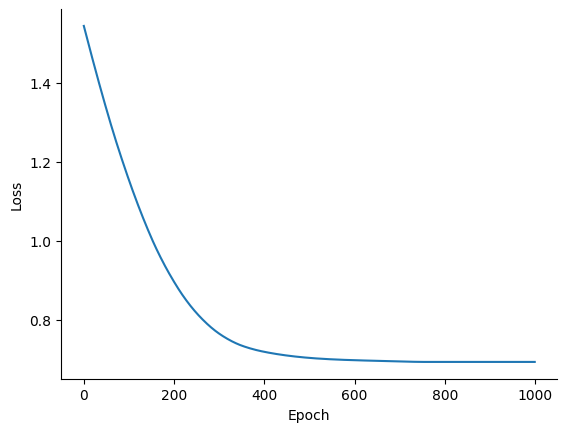

In [ ]:
plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
sns.despine()

In [ ]:
print_class_accuracy()

Accuracy 0.496


The reason why the classification accuracy is still bad is because there is a 0 gradient for the hidden layer. Thus, there is never any update to the hidden layer during training. The reason why the loss goes down is the gradient at the output layer weights can change because they do not get passed through a heavyside function.

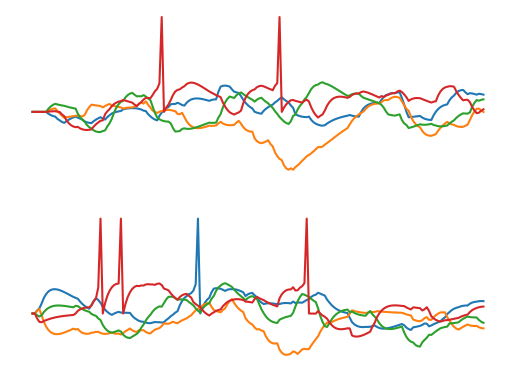

In [ ]:
# This shows how the weights after the hidden layer are not updated
# The hidden units behave the same way after training as they did before

output,other_recordings = run_snn(x_data)
mem_rec, spk_rec = other_recordings
fig=plt.figure(dpi=100)
plot_voltage_traces(mem_rec, spk_rec)

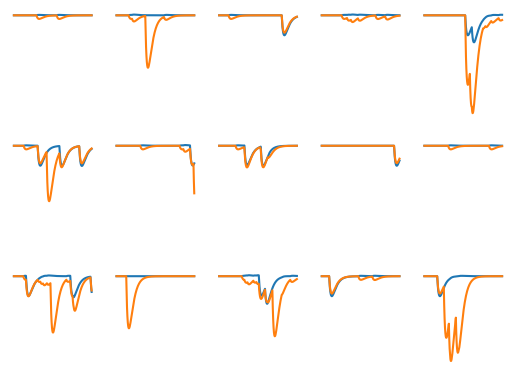

In [ ]:
fig=plt.figure(dpi=100)
plot_voltage_traces(output, dim=(3, 5))

Supervised learning with surrogate gradients

In [ ]:
class SurrGradSpike(torch.autograd.Function):
  """
  Here we implement our spiking nonlinearity which also implements the surrogate
  gradient. By subclassing torch.autograd.Function, we will be able to use all of
  PyTorch's autograd functionality. Here we used the normalized negative part of
  a fast sigmoid as done in Zenke & Ganguli (2018).
  """

  scale = 100. # Controls the steepness of the gradient

  @staticmethod
  def forward(ctx, input):
    """
    In the forward pass we compute a step function of the input Tensor and return
    it. ctx is a context object that we use to stash information which we need to
    later backpropogate our error signal. To achieve this, we use the
    ctx.save_for_backward method.
    """
    ctx.save_for_backward(input)
    out = torch.zeros_like(input)
    out[input > 0] = 1.0
    return out

  @staticmethod
  def backward(ctx, grad_output):
    """
    In the backward pass we recieve a Tensor and we need to compute the surrogate
    gradient of the loss with respect to the input. Here we use the normalized
    negative part of a fast sigmoid as this was done in Zenke & Ganguli (2018).
    """
    input, = ctx.saved_tensors
    grad_input = grad_output.clone()
    grad = grad_input / (SurrGradSpike.scale * torch.abs(input) + 1.0) ** 2

    return grad

# Here we override the naive spike function by the "SurrGradSpike" nonlinearity
# which implements a surrogate gradient
spike_fn = SurrGradSpike.apply

In [ ]:
# The following lines will reinitialize the weights
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

tensor([[ 0.1598,  0.2956],
        [ 0.9293, -0.6411],
        [ 0.1206,  0.0214],
        [-0.0122, -0.0224]], requires_grad=True)

In [ ]:
# Training the new network
params = [w1, w2]
optimizer = torch.optim.Adam(params, lr=2e-3, betas=(0.9, 0.999))

log_softmax_fn = nn.LogSoftmax(dim=1)
loss_fn = nn.NLLLoss()

lost_hist = []
for e in range(1000):
  output, _ = run_snn(x_data)
  m, _ = torch.max(output, 1)
  log_p_y = log_softmax_fn(m)
  loss_val = loss_fn(log_p_y, y_data)

  optimizer.zero_grad()
  loss_val.backward()
  optimizer.step()
  loss_hist.append(loss_val.item())

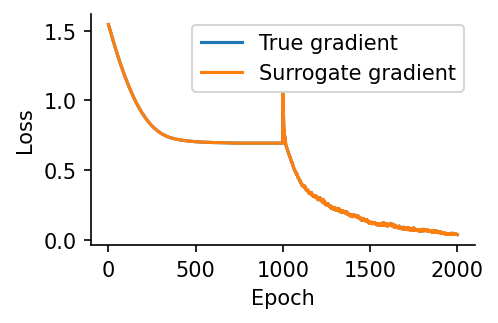

In [ ]:
plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(loss_hist_true_grad, label="True gradient")
plt.plot(loss_hist, label="Surrogate gradient")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
sns.despine()

In [ ]:
output, other_recordings = run_snn(x_data)
mem_rec, spk_rec = other_recordings

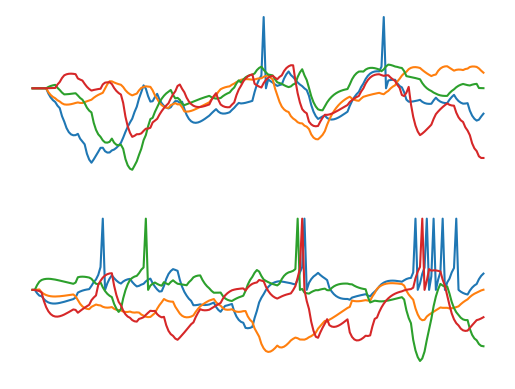

In [ ]:
fig = plt.figure(dpi=100)
plot_voltage_traces(mem_rec, spk_rec)

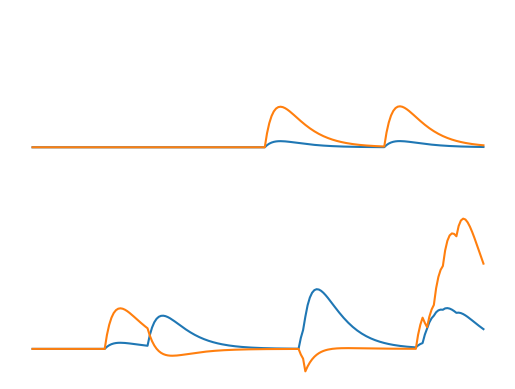

In [ ]:
fig = plt.figure(dpi=100)
plot_voltage_traces(output)

In [ ]:
output,_ = run_snn(x_data)
m,_=torch.max(output,1)

# Compute training accuracy
_,am=torch.max(m,1)
acc = np.mean((y_data==am).detach().cpu().numpy())
print("Accuracy %f"%acc)

Accuracy 0.988281


In [ ]:
x_data

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 